# TP2 : Image classification

* 1 Bag-of-Words Classication with Histograms Oriented Gradients

In [36]:
import cv2
import numpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve
import scipy.ndimage as ndimage
import pandas as pd

Indices X : [ 0. 19. 38. 57. 76. 95.  0. 19. 38. 57.]
Indices Y : [ 0.  0.  0.  0.  0.  0. 19. 19. 19. 19.]


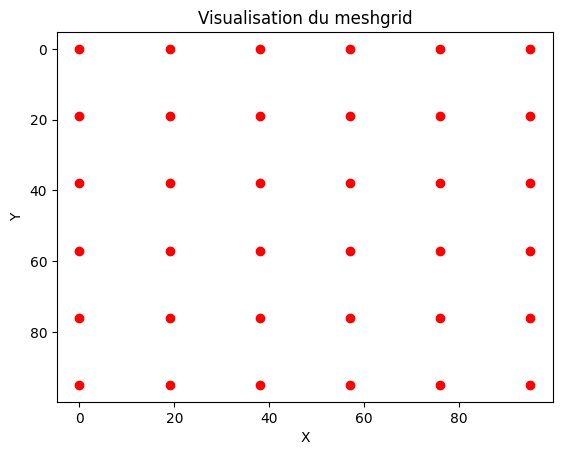

In [37]:
def grid(image, n_points_x, n_points_y):
    
    # Get the shape of the image
    height, width = image.shape
    
    # Compute the 1D vectors 
    X_vect = numpy.linspace(0, width-1, n_points_x)
    Y_vect = numpy.linspace(0, height-1, n_points_y)
    
    # Creating the meshgrid
    X, Y = numpy.meshgrid(X_vect, Y_vect)

    # Flatens the matrix to get a vector with cordinated
    X_flat = X.ravel()
    Y_flat = Y.ravel()

    return X_flat, Y_flat, X, Y

# Exemple d'utilisation
image = cv2.imread('STL10/stl10_raw/test/airplane/airplane_test_001.png')

# Convertir l'image en niveaux de gris (important pour que la fonction grid fonctionne correctement)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

n_points_x = 6 # Nombre de points dans la direction x
n_points_y = 6  # Nombre de points dans la direction y
# Appel de la fonction
X_flat, Y_flat, X, Y = grid(image_gray, n_points_x, n_points_y)

# Affichage des premiers résultats pour visualiser la grille
print("Indices X :", X_flat[:10])
print("Indices Y :", Y_flat[:10])

plt.scatter(X, Y, c='r', marker='o')  # Utilisation de scatter pour visualiser la grille de points
plt.gca().invert_yaxis()  # Inverser l'axe Y pour correspondre aux coordonnées d'image
plt.title('Visualisation du meshgrid')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [38]:
def compute_hog_descriptors(image, X_flat, Y_flat, cell_size=4, num_bins=8, patch_size=16):
    """
    param image: image (grayscale)
    :param X_flat: 1D vector of x coordinates
    :param Y_flat: 1D vector of y coordinates
    :param cell_size: cell size (par défaut 4x4 pixels)
    :param num_bins: number of bins of each patch (8 by default)
    :return: 2D array containing hog descriptors for each point of the grid
    """
    hog_descriptors = []
    height, width = image.shape

    # Comoute the image gradient (using Sobel)
    gx = ndimage.sobel(image, axis=1)  # Gradient in x
    gy = ndimage.sobel(image, axis=0)  # Gradient in y

    # Compute the magnitude and direction of the gradient
    magnitude = np.sqrt(gx**2 + gy**2)
    direction = np.arctan2(gy, gx)  

    # Put it in angle form
    direction = np.mod(direction, 2 * np.pi)


    # Pour chaque point de la grille, calculer le descripteur HOG
    for x, y in zip(X_flat, Y_flat):
        x, y = int(x), int(y)

        # Calculer à quel patch le point appartient
        x_patch_min = (x // patch_size) * patch_size
        y_patch_min = (y // patch_size) * patch_size

        # Fixer les limites du patch
        x_min = x_patch_min
        x_max = min(x_min + patch_size, width)
        y_min = y_patch_min
        y_max = min(y_min + patch_size, height)

        # Extraire la magnitude et la direction des gradients pour le patch de 16x16 pixels
        patch_magnitude = magnitude[y_min:y_max, x_min:x_max]
        patch_direction = direction[y_min:y_max, x_min:x_max]

        # Divide the patch into a 4x4 cells
        hog_vector = []
        
        # For each cell we compute the histogram
        for i in range(0, patch_magnitude.shape[0], cell_size):
            for j in range(0, patch_magnitude.shape[1], cell_size):
                # Extract the 4x4 cell from the patch
                cell_magnitude = patch_magnitude[i:i+cell_size, j:j+cell_size]
                cell_direction = patch_direction[i:i+cell_size, j:j+cell_size]

                # Create a histogram for that cell
                hist, _ = np.histogram(
                    cell_direction, bins=num_bins, range=(0, 2 * np.pi),
                    weights=cell_magnitude
                )

                # Append every histogram for each cell to the vector
                hog_vector.extend(hist)

        # Apend the histogram of this patch to the list of hog descriptor
        hog_descriptors.append(hog_vector)

    # Return the array of the HOG descriptor
    return np.array(hog_descriptors)

HOG_D = compute_hog_descriptors(image_gray, X_flat, Y_flat)



In [39]:
def display_hog_matrix(hog_descriptors):
    """
    Show informations of the hog descriptors
    
    :param hog_descriptors: 2D matrix of the hog descriptor (n_points x 128)
    """
    print("Shape of the HOG descriptors matrix:", hog_descriptors.shape)
    print("\nFirst 5 rows of the HOG descriptors matrix:\n", hog_descriptors[:5])  # Afficher les 5 premières lignes

# Example for an image
hog_descriptors = compute_hog_descriptors(image_gray, X_flat, Y_flat)
display_hog_matrix(hog_descriptors)



Shape of the HOG descriptors matrix: (36, 128)

First 5 rows of the HOG descriptors matrix:
 [[ 13.41   18.72    6.      0.      0.      0.      0.      0.      8.33
   28.9     2.      0.      0.      0.      0.      0.     12.33   37.1
    6.      0.      0.      0.      0.      0.     19.16    9.57   10.
    0.      0.      0.      0.      0.     33.8    11.55    8.      0.
    0.      0.      0.      0.     16.47   15.555   4.      0.      0.
    0.      0.      0.      9.16   30.94   10.      0.      0.      0.
    0.      0.     10.99   41.22    4.      0.      0.      0.      0.
    0.     12.46   30.22    2.      0.      0.      0.      0.      0.
   15.734  17.64    2.      0.      0.      0.      0.      0.     19.88
    8.82    8.      0.      0.      0.      0.      0.     17.03   16.78
    0.      0.      0.      0.      0.      0.     12.21   22.06    2.
    0.      0.      0.      0.      0.     11.984  34.6     0.      0.
    0.      0.      0.      0.     11.164   9.16

In [56]:
import os
import cv2

def load_images_from_folders(root_folder, class_mapping):
    """
    Loads all grayscale images from subfolders of a root folder, using a specified class mapping.
    
    :param root_folder: Path to the root folder containing class subfolders.
    :param class_mapping: Dictionary mapping class folder names to class indices.
    :return: List of images and corresponding labels (class indices).
    """
    images = []
    labels = []

    # Loop through all class folders
    for folder_name, class_index in class_mapping.items():
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                image_path = os.path.join(folder_path, filename)
                # Load the image in grayscale
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    images.append(image)
                    labels.append(class_index)  # Assign the class label based on the mapping
    return images, labels

# Define a consistent class mapping
class_mapping = {
    'airplane': 0,
    'bird': 1,
    'car': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'horse': 6,
    'monkey': 7,
    'ship': 8,
    'truck': 9
}

# Example usage
root_folder_train = 'STL10/stl10_raw/train'  # Path to the root folder containing class subfolders
root_folder_test = 'STL10/stl10_raw/test'
train_images, train_labels = load_images_from_folders(root_folder_train, class_mapping)
test_images, test_labels = load_images_from_folders(root_folder_test, class_mapping)

In [83]:
#print(test_labels)
#print(train_labels)

In [59]:
def compute_hog_for_all_images(images, X_flat, Y_flat):
    """
    Computes HOG descriptors for all images in the dataset and stores them in a single list.
    
    :param images: List of grayscale images.
    :param X_flat, Y_flat: Grid points for HOG descriptor extraction.
    :return: A list containing the HOG descriptors for each image and a combined matrix of all HOG descriptors.
    """
    all_hog_descriptors = []  # To store HOG descriptors for all images
    combined_hog_matrix = []  # To store all HOG descriptors in one matrix (for K-means, etc.)

    for i, image in enumerate(images):
        # Compute HOG descriptors for the current image
        hog_descriptors = compute_hog_descriptors(image, X_flat, Y_flat)

        # Append the HOG descriptors of this image to the list
        all_hog_descriptors.append(hog_descriptors)

        # Combine HOG descriptors into a single matrix for all images
        combined_hog_matrix.append(hog_descriptors)

    # Convert the combined matrix to a 2D NumPy array
    combined_hog_matrix = np.vstack(combined_hog_matrix)

    return all_hog_descriptors, combined_hog_matrix



In [60]:
import numpy as np
from scipy.spatial.distance import cdist

def kmeans_clustering(hog_descriptors, K, max_iters=100, tol=1e-4):
    """
    Implements the K-means clustering algorithm to build a visual vocabulary.
    
    :param hog_descriptors: 2D array (n_samples x 128) containing HOG descriptors from all images
    :param K: Number of clusters (size of the visual vocabulary)
    :param max_iters: Maximum number of iterations for K-means (default 100)
    :param tol: Tolerance to stop the algorithm when centroids converge (default 1e-4)
    :return: 2D array of size K x 128 containing the final cluster centroids (visual words)
    """
    # Step 1: Randomly initialize the cluster centroids
    n_samples, n_features = hog_descriptors.shape
    print(hog_descriptors.shape)
    centroids = hog_descriptors[np.random.permutation(n_samples)[:K]]  # Randomly select K centroids from data

    for iteration in range(max_iters):
        # Step 2: Assign each descriptor to the nearest centroid (using Euclidean distance)
        distances = cdist(hog_descriptors, centroids, 'euclidean')
        labels = np.argmin(distances, axis=1)  # Find the nearest centroid for each descriptor

        # Save the current centroids to check convergence later
        previous_centroids = centroids.copy()

        # Step 3: Update centroids by calculating the mean of all descriptors assigned to each centroid
        for k in range(K):
            points_in_cluster = hog_descriptors[labels == k]
            if len(points_in_cluster) > 0:
                centroids[k] = points_in_cluster.mean(axis=0)  # New centroid is the mean of all assigned points

        # Check for convergence (if centroids don't change much)
        centroid_shift = np.linalg.norm(centroids - previous_centroids, axis=1).max()
        if centroid_shift < tol:
            print(f"K-means converged after {iteration+1} iterations.")
            break

    return centroids

# Example usage with sample HOG descriptors
# Assume hog_descriptors is a 2D array (n_samples x 128) containing all HOG descriptors from training images


In [61]:
# X_flat and Y_flat are the grid coordinates for extracting HOG descriptors for both train et test set
all_hog_descriptors_train, combined_hog_matrix_train = compute_hog_for_all_images(train_images, X_flat, Y_flat)
all_hog_descriptors_test, combined_hog_matrix_test = compute_hog_for_all_images(test_images, X_flat, Y_flat)

#Perform K-means clustering on the combined HOG descriptors matrix
K = 50  # Number of clusters (size of the visual vocabulary)
vocabulary = kmeans_clustering(combined_hog_matrix_train, K)

#Visualize the resulting vocabulary shape
print("Visual vocabulary (centroids):", vocabulary.shape)


(180000, 128)
Visual vocabulary (centroids): (50, 128)


In [97]:
def compute_bow_histograms(hog_descriptors_list, vocabulary, labels):
    """
    Computes the BoW histograms for all images in the dataset.
    
    :param hog_descriptors_list: List of 2D arrays, where each array contains the HOG descriptors of an image
    :param vocabulary: 2D array (K x 128) of visual words (centroids from K-means)
    :param labels: List or array containing the ground truth labels for each image
    :return: 2D array of shape (n_images, K) containing the BoW histograms, and 1D array of ground truth labels
    """
    K = vocabulary.shape[0]  # Number of clusters (visual words)
    n_images = len(hog_descriptors_list)

    # Initialize the BoW histograms and ground truth labels arrays
    bow_histograms = np.zeros((n_images, K))
    ground_truth_labels = np.array(labels)

    # For each image, compute the BoW histogram
    for i, hog_descriptors in enumerate(hog_descriptors_list):
        # Compute distances between each HOG descriptor and the vocabulary (centroids)
        distances = cdist(hog_descriptors, vocabulary, 'euclidean')

        # Find the nearest centroid (visual word) for each descriptor
        nearest_centroids = np.argmin(distances, axis=1)

        # Count the occurrences of each visual word using np.bincount
        bow_histogram = np.bincount(nearest_centroids, minlength=K)

        # Normalize the histogram to get a distribution (optional but recommended)
        bow_histogram = bow_histogram / np.sum(bow_histogram)

        # Store the BoW histogram for this image
        bow_histograms[i, :] = bow_histogram

    return bow_histograms, ground_truth_labels

# Example usage
# Assume hog_descriptors_list is a list where each element is a 2D array (n_patches x 128) of HOG descriptors for an image
# Assume vocabulary is the array of centroids from K-means
# Assume labels is the list of ground truth labels for each image

bow_histograms_train, ground_truth_labels_train = compute_bow_histograms(all_hog_descriptors_train, vocabulary, train_labels)
bow_histograms_test, ground_truth_labels_test = compute_bow_histograms(all_hog_descriptors_test, vocabulary, test_labels)

# Print the shape of the resulting BoW histograms and ground truth labels
print(f"BoW histograms shape: {bow_histograms_train.shape}")
print(f"Ground truth labels shape: {ground_truth_labels_test.shape}")

print(len(bow_histograms_test))

BoW histograms shape: (5000, 100)
Ground truth labels shape: (8000,)
8000


In [98]:

# Print the length of the BoW histograms to check they match the number of images
print(f"Number of BoW histograms in training set: {len(bow_histograms_train)}")  # Should match the number of training images (e.g., 1000)
print(f"Number of BoW histograms in test set: {len(bow_histograms_test)}")  # Should match the number of test images (e.g., 1600)

Number of BoW histograms in training set: 5000
Number of BoW histograms in test set: 8000


In [100]:
import numpy as np
from scipy.spatial.distance import cdist

def knn_classifier(train_bow_histograms, train_labels, test_bow_histograms, k=3):
    """
    Implements a k-Nearest Neighbors (k-NN) classifier using Euclidean (L2) distance.
    
    :param train_bow_histograms: 2D array (n_train_samples x K) containing the BoW histograms of the training images
    :param train_labels: 1D array (n_train_samples) containing the labels of the training images
    :param test_bow_histograms: 2D array (n_test_samples x K) containing the BoW histograms of the test images
    :param k: The number of nearest neighbors to consider (default is 3)
    :return: 1D array (n_test_samples) containing the predicted labels for the test images
    """
    #convert trainlables to a numpy
    train_labels = np.array(train_labels)
    
    # Step 1: Compute the distances between each test BoW histogram and all train BoW histograms
    distances = cdist(test_bow_histograms, train_bow_histograms, 'euclidean')

    # Step 2: Find the indices of the k nearest neighbors for each test image
    nearest_neighbors = np.argsort(distances, axis=1)[:, :k]

    # Step 3: Predict the label of each test image based on the majority vote of its k nearest neighbors
    predicted_labels = []
    for neighbors in nearest_neighbors:
        # Get the labels of the k nearest neighbors
        neighbor_labels = train_labels[neighbors]

        # Find the most common label (majority vote)
        unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
        majority_label = unique_labels[np.argmax(counts)]

        # Append the predicted label
        predicted_labels.append(majority_label)

    return np.array(predicted_labels)

# Example usage:
# train_bow_histograms: BoW histograms of the training images (shape: n_train_samples x K)
# train_labels: Labels of the training images (shape: n_train_samples)
# test_bow_histograms: BoW histograms of the test images (shape: n_test_samples x K)

k = 3  # Number of neighbors to consider
predicted_labels = knn_classifier(bow_histograms_train, train_labels, bow_histograms_test, k)

# Print predicted labels for the test set
print("Predicted labels for test images:", predicted_labels)

Predicted labels for test images: [2 1 0 ... 8 2 6]


# Experiments

1. With 2 classes   

First one between birds and airplane

In [102]:
def filter_airplane_bird(hog_descriptors_list, labels):
    """
    Filter the HOG descriptors to keep only the "airplane" (0) and "bird" (1) classes.
    
    :param hog_descriptors_list: List of HOG descriptors (one 2D array per image)
    :param labels: Array of corresponding labels for the dataset.
    :return: Filtered HOG descriptors and labels containing only airplane and bird classes.
    """
    filtered_descriptors = []
    filtered_labels = []
    for descriptors, label in zip(hog_descriptors_list, labels):
        if label == 0 or label == 1:  # Keep only airplane (0) and bird (1)
            filtered_descriptors.append(descriptors)
            filtered_labels.append(label)
    return np.array(filtered_descriptors), np.array(filtered_labels)

# Filter the training and test sets to keep only airplane and bird classes
filtered_train_descriptors, filtered_train_labels = filter_airplane_bird(all_hog_descriptors_train, train_labels)
filtered_test_descriptors, filtered_test_labels = filter_airplane_bird(all_hog_descriptors_test, test_labels)

In [106]:
# Apply K-means clustering on the HOG descriptors from the training set (airplane and bird only)
vocabulary1 = kmeans_clustering(combined_hog_matrix_train, K=100, max_iters=10)


(180000, 128)


In [107]:
# Calculate BoW histograms for the training and test sets using the vocabulary
bow_histograms_train1, ground_truth_labels_train1 = compute_bow_histograms(filtered_train_descriptors, vocabulary1, filtered_train_labels)
bow_histograms_test1, ground_truth_labels_test1 = compute_bow_histograms(filtered_test_descriptors, vocabulary1, filtered_test_labels)

# Print the length of the BoW histograms to check they match the number of images
print(f"Number of BoW histograms in training set: {len(bow_histograms_train)}")  # Should match the number of training images (e.g., 1000)
print(f"Number of BoW histograms in test set: {len(bow_histograms_test)}")  # Should match the number of test images (e.g., 1600)

Number of BoW histograms in training set: 5000
Number of BoW histograms in test set: 8000


In [89]:
from sklearn.metrics import accuracy_score

# Use k-NN to predict the labels for the test images
predicted_labels = knn_classifier(bow_histograms_train1, filtered_train_labels, bow_histograms_test1, k=3)
print(len(predicted_labels))
# Print accuracy for the "airplane" and "bird" classes
accuracy = accuracy_score(filtered_test_labels, predicted_labels)
print(f"Accuracy for airplane and bird: {accuracy * 100:.2f}%")


1600
Accuracy for airplane and bird: 70.31%
1600
1600
1000


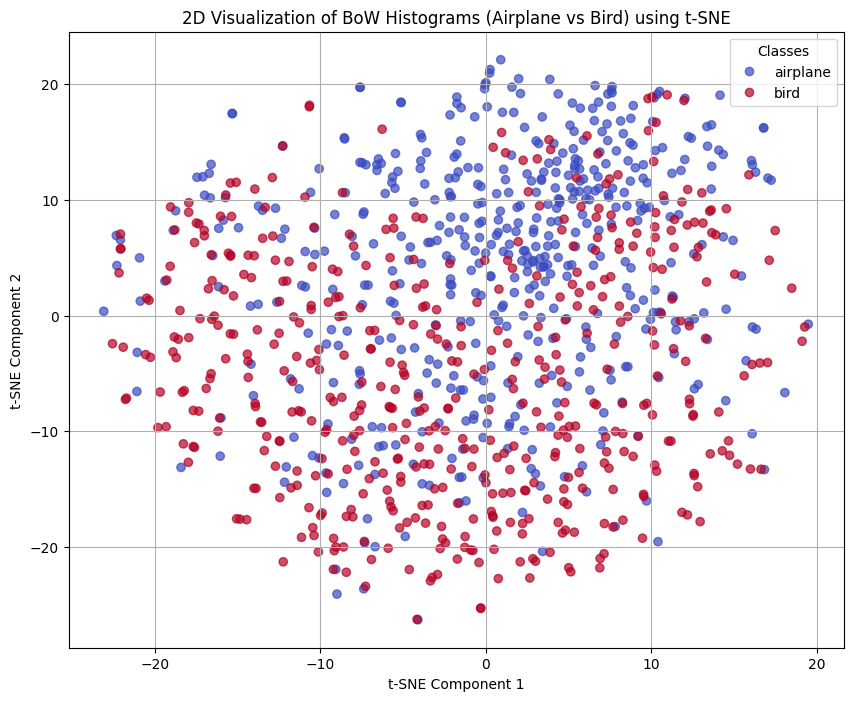

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def visualize_airplane_bird_2d(bow_histograms, labels):
    """
    Visualize BoW histograms in 2D using t-SNE for the airplane and bird classes.
    
    :param bow_histograms: 2D array of BoW histograms (n_samples x K) for airplane and bird
    :param labels: 1D array of labels corresponding to airplane and bird images
    """
    # Standardize the BoW histograms before applying t-SNE
    scaler = StandardScaler()
    bow_histograms_scaled = scaler.fit_transform(bow_histograms)

    # Apply t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    bow_histograms_2d = tsne.fit_transform(bow_histograms_scaled)

    # Plotting the 2D projection with different colors for each class
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(bow_histograms_2d[:, 0], bow_histograms_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)

    # Create a legend with class names
    plt.legend(handles=scatter.legend_elements()[0], labels=['airplane', 'bird'], title="Classes")

    plt.title("2D Visualization of BoW Histograms (Airplane vs Bird) using t-SNE")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.show()

# Example usage for the filtered "airplane" and "bird" classes
visualize_airplane_bird_2d(bow_histograms_train1, filtered_train_labels)

Here between horses and deers

In [152]:
def filter_horse_deer(hog_descriptors_list, labels):
    """
    Filter the HOG descriptors to keep only the "airplane" (0) and "bird" (1) classes.
    
    :param hog_descriptors_list: List of HOG descriptors (one 2D array per image)
    :param labels: Array of corresponding labels for the dataset.
    :return: Filtered HOG descriptors and labels containing only airplane and bird classes.
    """
    filtered_descriptors = []
    filtered_labels = []
    for descriptors, label in zip(hog_descriptors_list, labels):
        if label == 5 or label == 4:  # Keep only horse (5) and dear (4)
            filtered_descriptors.append(descriptors)
            filtered_labels.append(label)
    return np.array(filtered_descriptors), np.array(filtered_labels)

# Filter the training and test sets to keep only airplane and bird classes
filtered_train_descriptors2, filtered_train_labels2 = filter_horse_deer(all_hog_descriptors_train, train_labels)
filtered_test_descriptors2, filtered_test_labels2 = filter_horse_deer(all_hog_descriptors_test, test_labels)

In [153]:
# Apply K-means clustering on the HOG descriptors from the training set (airplane and bird only)
vocabulary1 = kmeans_clustering(combined_hog_matrix_train, K=100, max_iters=10)


(180000, 128)


In [154]:
# Calculate BoW histograms for the training and test sets using the vocabulary
bow_histograms_train2, ground_truth_labels_train2 = compute_bow_histograms(filtered_train_descriptors, vocabulary1, filtered_train_labels2)
bow_histograms_test2, ground_truth_labels_test2 = compute_bow_histograms(filtered_test_descriptors, vocabulary1, filtered_test_labels2)

# Print the length of the BoW histograms to check they match the number of images
print(f"Number of BoW histograms in training set: {len(bow_histograms_train)}")  # Should match the number of training images (e.g., 1000)
print(f"Number of BoW histograms in test set: {len(bow_histograms_test)}")  # Should match the number of test images (e.g., 1600)

Number of BoW histograms in training set: 5000
Number of BoW histograms in test set: 8000


In [155]:
from sklearn.metrics import accuracy_score

# Use k-NN to predict the labels for the test images
predicted_labels2 = knn_classifier(bow_histograms_train2, filtered_train_labels2, bow_histograms_test2, k=3)
print(len(predicted_labels2))
# Print accuracy for the "airplane" and "bird" classes
accuracy = accuracy_score(filtered_test_labels2, predicted_labels2)
print(f"Accuracy for horse and deer: {accuracy * 100:.2f}%")


1600
Accuracy for horse and deer: 71.12%


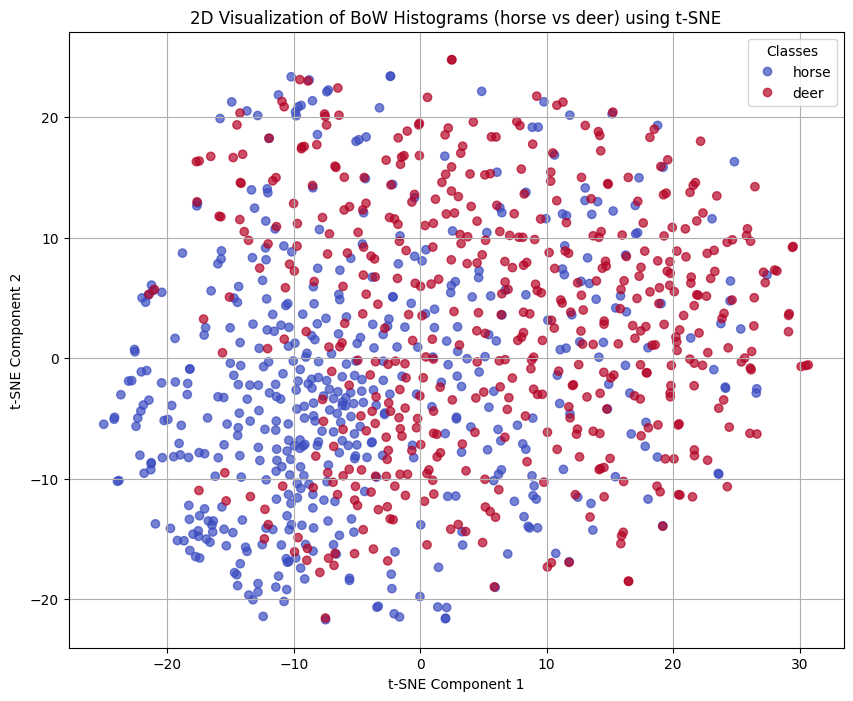

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def visualize_horse_deer_2d(bow_histograms, labels):
    """
    Visualize BoW histograms in 2D using t-SNE for the airplane and bird classes.
    
    :param bow_histograms: 2D array of BoW histograms (n_samples x K) for airplane and bird
    :param labels: 1D array of labels corresponding to airplane and bird images
    """
    # Standardize the BoW histograms before applying t-SNE
    scaler = StandardScaler()
    bow_histograms_scaled = scaler.fit_transform(bow_histograms)

    # Apply t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    bow_histograms_2d = tsne.fit_transform(bow_histograms_scaled)

    # Plotting the 2D projection with different colors for each class
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(bow_histograms_2d[:, 0], bow_histograms_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)

    # Create a legend with class names
    plt.legend(handles=scatter.legend_elements()[0], labels=['horse', 'deer'], title="Classes")

    plt.title("2D Visualization of BoW Histograms (horse vs deer) using t-SNE")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.show()

# Example usage for the filtered "airplane" and "bird" classes
visualize_horse_deer_2d(bow_histograms_train2, filtered_train_labels2)

In [108]:
n_runs = 10  # Number of runs for training and evaluation
accuracies = []  # Store accuracy results for each run

for run in range(n_runs):
    # Re-train K-means for each run
    vocabulary = kmeans_clustering(combined_hog_matrix_train, K=100, max_iters=10)

    # Recompute the BoW histograms with the new vocabulary
    bow_histograms_train1, ground_truth_labels_train1  = compute_bow_histograms(filtered_train_descriptors, vocabulary1, filtered_train_labels)
    bow_histograms_test1, ground_truth_labels_test1 = compute_bow_histograms(filtered_test_descriptors, vocabulary1, filtered_test_labels)

    # Predict the labels for the test set using k-NN
    predicted_labels = knn_classifier(bow_histograms_train1, filtered_train_labels, bow_histograms_test1, k=3)

    # Compute and store the accuracy for this run
    accuracy = accuracy_score(filtered_test_labels, predicted_labels)
    accuracies.append(accuracy)
    print(f"Run {run + 1}: Accuracy = {accuracy * 100:.2f}%")

# Calculate and print the mean accuracy over all 10 runs
mean_accuracy = np.mean(accuracies)
print(f"Mean accuracy over 10 runs: {mean_accuracy * 100:.2f}%")

(180000, 128)
Run 1: Accuracy = 72.06%
(180000, 128)
Run 2: Accuracy = 72.06%
(180000, 128)
Run 3: Accuracy = 72.06%
(180000, 128)
Run 4: Accuracy = 72.06%
(180000, 128)
Run 5: Accuracy = 72.06%
(180000, 128)
Run 6: Accuracy = 72.06%
(180000, 128)
Run 7: Accuracy = 72.06%
(180000, 128)
Run 8: Accuracy = 72.06%
(180000, 128)
Run 9: Accuracy = 72.06%
(180000, 128)
Run 10: Accuracy = 72.06%
Mean accuracy over 10 runs: 72.06%


2. With the full STL10 dataset i.e. all ten classes

In [104]:
# Use k-NN to classify the images across all 10 classes
predicted_labels_10_classes = knn_classifier(bow_histograms_train, train_labels, bow_histograms_test, k=3)
print(len(predicted_labels_10_classes))  # Check the number of predicted labels

# Calculate the accuracy of the BoW model on the full STL-10 dataset (with 10 classes)
accuracy_10_classes = accuracy_score(test_labels, predicted_labels_10_classes)
print(f"Accuracy on the full STL-10 dataset (10 classes): {accuracy_10_classes * 100:.2f}%")

# Implement a random classifier by randomly selecting class labels
random_predicted_labels = np.random.choice(np.unique(test_labels), size=len(test_labels))
random_accuracy = accuracy_score(test_labels, random_predicted_labels)
print(f"Accuracy of random classifier: {random_accuracy * 100:.2f}%")

# Comparison with the results obtained for only 2 classes
# You will need to compare this accuracy with the one you obtained during the binary classification (airplane vs bird).

8000
Accuracy on the full STL-10 dataset (10 classes): 23.10%
Accuracy of random classifier: 9.47%


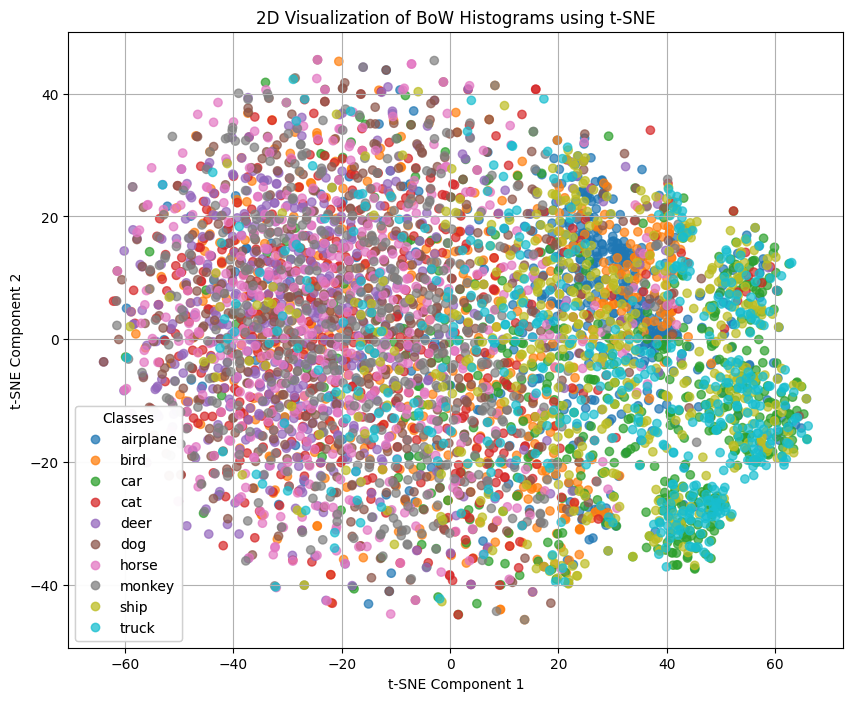

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def visualize_classes_2d(bow_histograms, labels, class_names):
    """
    Visualize BoW histograms in 2D using t-SNE.

    :param bow_histograms: 2D array of BoW histograms (n_samples x K)
    :param labels: 1D array of labels corresponding to the images
    :param class_names: List of class names
    """
    # Standardize the BoW histograms before applying t-SNE
    scaler = StandardScaler()
    bow_histograms_scaled = scaler.fit_transform(bow_histograms)

    # Apply t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    bow_histograms_2d = tsne.fit_transform(bow_histograms_scaled)

    # Plotting the 2D projection with different colors for each class
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(bow_histograms_2d[:, 0], bow_histograms_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)

    # Create a legend with class names
    legend = plt.legend(handles=scatter.legend_elements()[0], labels=class_names, title="Classes")
    plt.gca().add_artist(legend)

    plt.title("2D Visualization of BoW Histograms using t-SNE")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.show()

# Example usage
class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
visualize_classes_2d(bow_histograms_train, train_labels, class_names)

In [105]:
def compute_bow_histogramsL1(hog_descriptors_list, vocabulary, labels):
    """
    Computes the BoW histograms for all images in the dataset.
    
    :param hog_descriptors_list: List of 2D arrays, where each array contains the HOG descriptors of an image
    :param vocabulary: 2D array (K x 128) of visual words (centroids from K-means)
    :param labels: List or array containing the ground truth labels for each image
    :return: 2D array of shape (n_images, K) containing the BoW histograms, and 1D array of ground truth labels
    """
    K = vocabulary.shape[0]  # Number of clusters (visual words)
    n_images = len(hog_descriptors_list)

    # Initialize the BoW histograms and ground truth labels arrays
    bow_histograms = np.zeros((n_images, K))
    ground_truth_labels = np.array(labels)

    # For each image, compute the BoW histogram
    for i, hog_descriptors in enumerate(hog_descriptors_list):
        # Compute distances between each HOG descriptor and the vocabulary (centroids)
        distances = cdist(hog_descriptors, vocabulary, 'cityblock')

        # Find the nearest centroid (visual word) for each descriptor
        nearest_centroids = np.argmin(distances, axis=1)

        # Count the occurrences of each visual word using np.bincount
        bow_histogram = np.bincount(nearest_centroids, minlength=K)

        # Normalize the histogram to get a distribution (optional but recommended)
        bow_histogram = bow_histogram / np.sum(bow_histogram)

        # Store the BoW histogram for this image
        bow_histograms[i, :] = bow_histogram

    return bow_histograms, ground_truth_labels

# Example usage
# Assume hog_descriptors_list is a list where each element is a 2D array (n_patches x 128) of HOG descriptors for an image
# Assume vocabulary is the array of centroids from K-means
# Assume labels is the list of ground truth labels for each image

bow_histograms_train_L1, ground_truth_labels_train_L1 = compute_bow_histogramsL1(all_hog_descriptors_train, vocabulary, train_labels)
bow_histograms_test_L1, ground_truth_labels_test_L1 = compute_bow_histogramsL1(all_hog_descriptors_test, vocabulary, test_labels)

# Print the shape of the resulting BoW histograms and ground truth labels
print(f"BoW histograms shape: {bow_histograms_train.shape}")
print(f"Ground truth labels shape: {ground_truth_labels_test.shape}")


BoW histograms shape: (5000, 100)
Ground truth labels shape: (8000,)


In [157]:
import numpy as np
from sklearn.metrics import accuracy_score

def run_experiment_with_different_K(K_values, all_hog_descriptors_train, all_hog_descriptors_test, train_labels, test_labels):
    """
    Runs the BoW experiments for different values of K using both L1 and L2 norms, recalculating the vocabulary for each K.
    
    :param K_values: List of K values for the number of clusters (e.g., [50, 100, 200, 400])
    :param all_hog_descriptors_train: HOG descriptors for the training images
    :param all_hog_descriptors_test: HOG descriptors for the test images
    :param train_labels: Ground truth labels for training images
    :param test_labels: Ground truth labels for test images
    """
    for K in K_values:
        print(f"\nRunning experiment with K={K}")

        # Step 1: Recompute the visual vocabulary (K-means) for the current K
        vocabulary = kmeans_clustering(np.vstack(all_hog_descriptors_train), K=K, max_iters=10)

        # Step 2: Compute BoW histograms using L2 norm (Euclidean)
        bow_histograms_train_L2, _ = compute_bow_histograms(all_hog_descriptors_train, vocabulary, train_labels)
        bow_histograms_test_L2, _ = compute_bow_histograms(all_hog_descriptors_test, vocabulary, test_labels)

        # Step 3: Classify using k-NN (L2)
        predicted_labels_L2 = knn_classifier(bow_histograms_train_L2, train_labels, bow_histograms_test_L2, k=3)
        accuracy_L2 = accuracy_score(test_labels, predicted_labels_L2)

        # Step 4: Compute BoW histograms using L1 norm (Manhattan distance)
        bow_histograms_train_L1, _ = compute_bow_histogramsL1(all_hog_descriptors_train, vocabulary, train_labels)
        bow_histograms_test_L1, _ = compute_bow_histogramsL1(all_hog_descriptors_test, vocabulary, test_labels)

        # Step 5: Classify using k-NN (L1)
        predicted_labels_L1 = knn_classifier(bow_histograms_train_L1, train_labels, bow_histograms_test_L1, k=3)
        accuracy_L1 = accuracy_score(test_labels, predicted_labels_L1)

        print(f"L1 Norm Accuracy for K={K}: {accuracy_L1 * 100:.2f}% and L2 Norm Accuracy for K={K}: {accuracy_L2 * 100:.2f}%")

# Example usage:
K_values = [50, 100, 200, 400]
run_experiment_with_different_K(K_values, all_hog_descriptors_train, all_hog_descriptors_test, train_labels, test_labels)


Running experiment with K=50
(180000, 128)
L1 Norm Accuracy for K=50: 23.08% and L2 Norm Accuracy for K=50: 23.34%

Running experiment with K=100
(180000, 128)
L1 Norm Accuracy for K=100: 22.21% and L2 Norm Accuracy for K=100: 22.23%

Running experiment with K=200
(180000, 128)
L1 Norm Accuracy for K=200: 23.01% and L2 Norm Accuracy for K=200: 22.76%

Running experiment with K=400
(180000, 128)
L1 Norm Accuracy for K=400: 22.93% and L2 Norm Accuracy for K=400: 23.28%
